# Time Series Forecating using LSTM and Random Forest

**Importing libraries**

In [1]:
# Computational libraries
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# Plots
from matplotlib import pylab as plt

# RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNLSTM

# Random Forest
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

Using TensorFlow backend.
c:\users\aadity~1\downlo~1\linux\tsa-kwh\env_py35\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\aadity~1\downlo~1\linux\tsa-kwh\env_py35\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\aadity~1\downlo~1\linux\tsa-kwh\env_py35\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\us

In [2]:
%matplotlib inline

## Description

The given dataset is energy consumption readings of UK households starting from the year 2011 to 2014, The data is divided into categories which are based on the ACORN standard UK classification of households. Using this information the dataset is analyzed and two models are used to forecast the hoursly consumption.

**Reading Data**

In [3]:
df = pd.read_csv("data/Power-Networks-LCL.csv")

In [4]:
df.head()

,LCLid,stdorToU,DateTime,KWh,Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0.0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0.0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0.0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0.0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0.0,ACORN-A,Affluent


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999971 entries, 0 to 999970
Data columns (total 6 columns):
LCLid            999971 non-null object
stdorToU         999971 non-null object
DateTime         999971 non-null object
KWh              999971 non-null float64
Acorn            999971 non-null object
Acorn_grouped    999971 non-null object
dtypes: float64(1), object(5)
memory usage: 45.8+ MB


**Checking for all numeric fields**

In [6]:
df.describe()

,KWh
count,999971.000000
mean,0.239580
std,0.387533
min,0.000000
25%,0.060000
50%,0.129000
75%,0.255000
max,6.528000


**Converting DateTime to Datetime type from string**

In [7]:
df["DateTime"] = pd.to_datetime(df["DateTime"])

In [8]:
df.dtypes

LCLid                    object
stdorToU                 object
DateTime         datetime64[ns]
KWh                     float64
Acorn                    object
Acorn_grouped            object
dtype: object

**Checking for Working Day or not**

In [9]:
df["Working Day"] = df["DateTime"].apply(lambda x: 1 if x.dayofweek > 5 else 0)

**Generating DateTime Attributes**

In [10]:
df["Year"] = df["DateTime"].dt.year
df["Month"] = df["DateTime"].dt.month
df["Day"] = df["DateTime"].dt.day
df["Hour"] = df["DateTime"].dt.hour
df["Minute"] = df["DateTime"].dt.minute

## Visualizing Data

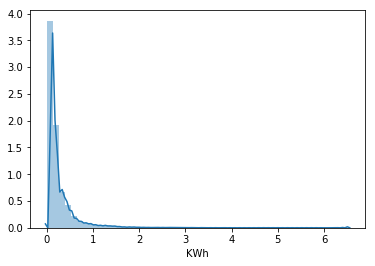

In [11]:
sns.distplot(df["KWh"])

Maximum consumtion in **2014**
Minimum consumtion in **2012**

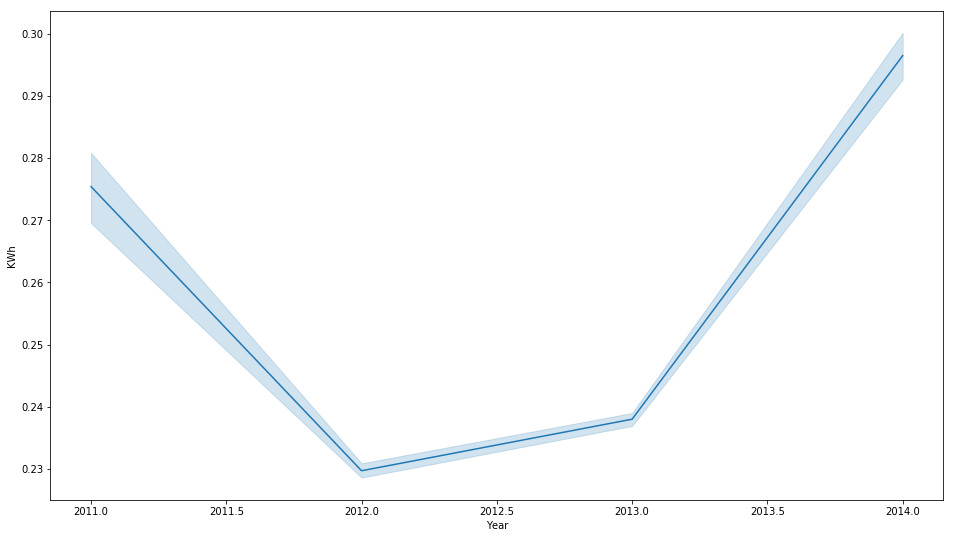

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Year"], y=df["KWh"], data=df, ax=ax)

Type-wise Yearly consumtion

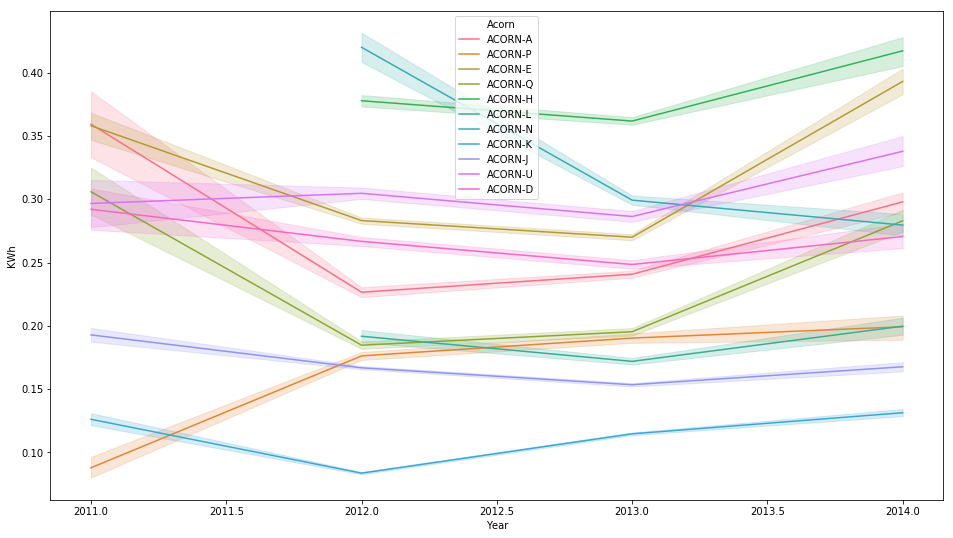

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Year"], y=df["KWh"], hue=df["Acorn"], data=df, ax=ax)

Group-wise Yearly consumption

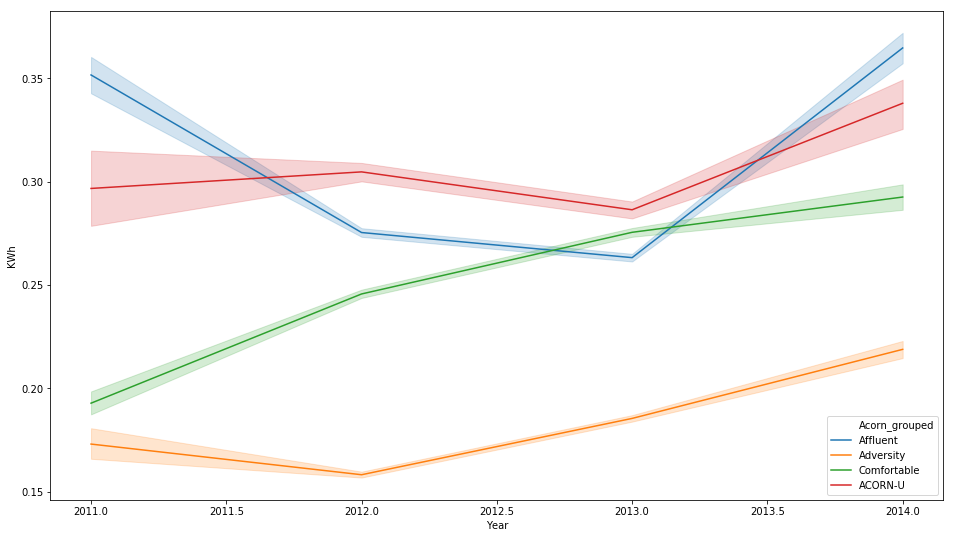

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Year"], y=df["KWh"], hue=df["Acorn_grouped"], data=df, ax=ax)

In [15]:
Hourly Consumption, shows a trend

SyntaxError: invalid syntax (<ipython-input-15-1966ed37aa41>, line 1)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Hour"], y=df["KWh"], data=df, ax=ax)

Type-wise hourly consumption

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Time"], y=df["KWh"], hue=df["Acorn"], data=df, ax=ax)

Group-wise hourly consumption

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Time"], y=df["KWh"], hue=df["Acorn_grouped"], data=df, ax=ax)

In [ ]:
Monthly Consumption, Seasonal Trend

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Month"], y=df["KWh"], data=df, ax=ax)

Type-wise monthly consumption

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Month"], y=df["KWh"], hue=df["Acorn"], data=df, ax=ax)

Group-wise monthly consumption

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=df["Month"], y=df["KWh"], hue=df["Acorn_grouped"], data=df, ax=ax)

## Data Preparation

Generating previous five datapoints

In [ ]:
for data in range(1, 6):
    df["Prev_" + str(data)] = df["KWh"].shift(data)

In [ ]:
df.fillna(0.00, inplace=True)

As all groups have different hourly behaviour, we create different dataframes and models for each

In [ ]:
acorn_df = {acorn:df[df["Acorn_grouped"] == acorn] for acorn in df["Acorn_grouped"].unique()}

In [ ]:
Encoding Categorical Data

In [ ]:
for acorn in acorn_df:
    acorn_df[acorn] = pd.get_dummies(acorn_df[acorn], columns=["Acorn"], prefix=["TYPE"])

Determining Useful Columns

In [ ]:
clean_cols = ["LCLid", "stdorToU", "DateTime", "Acorn_grouped", "Year", "Month", "Day",  "Hour", "Minute"]

In [ ]:
clean_acorn_df = {acorn:acorn_df[acorn].drop(clean_cols, axis=1) for acorn in acorn_df}

**Generating Train and Test data**

In [ ]:
train_acorn_df = {acorn: acorn_df[acorn][acorn_df[acorn]["DateTime"] < pd.to_datetime("2013-06-01")] for acorn in acorn_df}
test_acorn_df = {acorn: acorn_df[acorn][acorn_df[acorn]["DateTime"] >= pd.to_datetime("2013-08-01")] for acorn in acorn_df}
val_acorn_df = {acorn: acorn_df[acorn][(acorn_df[acorn]["DateTime"] >= pd.to_datetime("2013-06-01")) & (acorn_df[acorn]["DateTime"] < pd.to_datetime("2013-08-01"))] for acorn in acorn_df}

In [ ]:
clean_train_acorn_df = {acorn: train_acorn_df[acorn].drop(clean_cols, axis=1) for acorn in train_acorn_df}
clean_test_acorn_df = {acorn: test_acorn_df[acorn].drop(clean_cols, axis=1) for acorn in test_acorn_df}
clean_val_acorn_df = {acorn: val_acorn_df[acorn].drop(clean_cols, axis=1) for acorn in val_acorn_df}

In [ ]:
X_train, y_train = {acorn: clean_train_acorn_df[acorn].drop(["KWh"], axis=1) for acorn in clean_train_acorn_df}, {acorn: clean_train_acorn_df[acorn]["KWh"] for acorn in clean_train_acorn_df}
X_test, y_test = {acorn: clean_test_acorn_df[acorn].drop(["KWh"], axis=1) for acorn in clean_test_acorn_df}, {acorn: clean_test_acorn_df[acorn]["KWh"] for acorn in clean_test_acorn_df}
X_val, y_val = {acorn: clean_val_acorn_df[acorn].drop(["KWh"], axis=1) for acorn in clean_val_acorn_df}, {acorn: clean_val_acorn_df[acorn]["KWh"] for acorn in clean_val_acorn_df}

## Models and Predictions

**Random Forest Regressor**, scaling and fitting

In [ ]:
scaler = StandardScaler()
rfr  = {acorn: RandomForestRegressor(random_state=2020, verbose=2, n_jobs=5) for acorn in X_train}

In [ ]:
X_train_scaled = {acorn: scaler.fit_transform(X_train[acorn]) for acorn in X_train}
X_test_scaled = {acorn: scaler.fit_transform(X_test[acorn]) for acorn in X_test}
X_valid_scaled = {acorn: scaler.fit_transform(X_val[acorn]) for acorn in X_val}

In [ ]:
rfr_models = {acorn: rfr[acorn].fit(X_train_scaled[acorn], y_train[acorn]) for acorn in X_train_scaled}

**Validation Scores**

In [ ]:
for acorn in X_val:
    print(acorn, rfr[acorn].score(X_val[acorn], y_val[acorn]))

In [ ]:
for acorn in X_test:
    print(acorn, rfr[acorn].score(X_test[acorn], y_test[acorn]))

**Predictions and Comparisions**

In [ ]:
for acorn in X_test_scaled:
    test_acorn_df[acorn]["RF_Predictions"] = rfr[acorn].predict(X_test_scaled[acorn])

In [ ]:
for acorn in test_acorn_df:
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.lineplot(x=test_acorn_df[acorn]["Hour"], y=test_acorn_df[acorn]["KWh"], data=test_acorn_df[acorn], ax=ax, label="Original")
    sns.lineplot(x=test_acorn_df[acorn]["Hour"], y=test_acorn_df[acorn]["RF_Predictions"], data=test_acorn_df[acorn], ax=ax, label="Predictions")

**R^2 Score**

In [ ]:
for acorn in test_acorn_df:
    print(acorn, r2_score(test_acorn_df[acorn]["KWh"], test_acorn_df[acorn]["RF_Predictions"]))

**Mean Squared Error**

In [ ]:
for acorn in test_acorn_df:
    print(acorn, mean_squared_error(test_acorn_df[acorn]["KWh"], test_acorn_df[acorn]["RF_Predictions"]))

**Using LSTM RNN**

In [ ]:
models = {acorn: Sequential() for acorn in acorn_df}
for acorn in models:
    models[acorn].add(CuDNNLSTM(1, input_shape=(1, X_train[acorn].shape[1])))
    models[acorn].add(Dense(1))
    models[acorn].compile(loss='mean_squared_error', optimizer='adam')

**Converting to 3D**

In [ ]:
X_train_reshaped = {acorn: X_train_scaled[acorn].reshape((X_train_scaled[acorn].shape[0], 1, X_train_scaled[acorn].shape[1])) for acorn in X_train_scaled}

In [ ]:
X_test_reshaped = {acorn: X_test_scaled[acorn].reshape((X_test_scaled[acorn].shape[0], 1, X_test_scaled[acorn].shape[1])) for acorn in X_test_scaled}

In [ ]:
X_val_reshaped = {acorn: X_valid_scaled[acorn].reshape((X_valid_scaled[acorn].shape[0], 1, X_valid_scaled[acorn].shape[1])) for acorn in X_valid_scaled}

**Training the model**

In [ ]:
preds = {acorn: models[acorn].fit(X_train_reshaped[acorn], y_train[acorn], epochs=10, batch_size=2**12, verbose=2, validation_data=(X_val_reshaped[acorn], y_val[acorn])) for acorn in models}

In [ ]:
for acorn in preds:
    plt.plot(preds[acorn].history['loss'], label=acorn+'_train')
    plt.plot(preds[acorn].history['val_loss'], label=acorn+'_test')
    plt.legend()

In [ ]:
for acorn in models:
    test_acorn_df[acorn]["LSTM_Predictions"] = models[acorn].predict(X_test_reshaped[acorn])

In [ ]:
for acorn in test_acorn_df:
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.lineplot(x=test_acorn_df[acorn]["Hour"], y=test_acorn_df[acorn]["KWh"], data=test_acorn_df[acorn], ax=ax, label="Original")
    sns.lineplot(x=test_acorn_df[acorn]["Hour"], y=test_acorn_df[acorn]["LSTM_Predictions"], data=test_acorn_df[acorn], ax=ax, label="LSTM")

**Saving the models**

In [ ]:
for acorn in models:
    models[acorn].save("model_"+acorn+".h5")

## Conclusion

### LSTM vs RF

In [ ]:
for acorn in test_acorn_df:
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.lineplot(x=test_acorn_df[acorn]["Hour"], y=test_acorn_df[acorn]["KWh"], data=test_acorn_df[acorn], ax=ax, label="Original")
    sns.lineplot(x=test_acorn_df[acorn]["Hour"], y=test_acorn_df[acorn]["RF_Predictions"], data=test_acorn_df[acorn], ax=ax, label="Random Forest")
    sns.lineplot(x=test_acorn_df[acorn]["Hour"], y=test_acorn_df[acorn]["LSTM_Predictions"], data=test_acorn_df[acorn], ax=ax, label="LSTM")

Random Forest has marginally better performance than LSTM when we consider each group individually. Hence, it is the best model that can be used to predict the hourly energy consumption.